# Consigna del Desafío 3

#### Alumno: Diego Araujo

- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.

### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [137]:
import random
import io
import pickle

# Paquetes de manipulación y visualización

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Preprocesamiento
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional


# Para descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

### Datos
Como ejemplo se utilizará como corpus se utilizará el libro "El arte de la guerra" de Sun-Tzu para testear el modelo de generación de secuencias.

In [138]:
df = pd.read_csv('arte_guerra.txt', sep='/n', header=None, engine = 'python')
df.head()

,0
0,Sun Tzu El Arte de la Guerra
1,Capítulo 1. Sobre la evaluación
2,Sun Tzu dice: la guerra es de vital importanci...
3,Hay que valorarla en términos de cinco factore...
4,La doctrina significa aquello que hace que el ...


Vemos la cantidad de documentos del dataframe.


In [139]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 448


In [140]:
# Cada oración se guarda en una lista lo guardamos en una lista
text = list(df.loc[:,0])
text

['Sun Tzu El Arte de la Guerra',
 'Capítulo 1. Sobre la evaluación',
 'Sun Tzu dice: la guerra es de vital importancia para el Estado; es el dominio de la vida o de la muerte, el camino hacia la supervivencia o la pérdida del Imperio: es forzoso manejarla bien. No reflexionar seriamente sobre todo lo que le concierne es dar prueba de una culpable indiferencia en lo que respecta a la conservación o pérdida de lo que nos es mas querido; y ello no debe ocurrir entre nosotros.',
 'Hay que valorarla en términos de cinco factores fundamentales, y hacer comparaciones entre diversas condiciones de los bandos rivales, con vistas a determinar el resultado de la guerra. El primero de estos factores es la doctrina; el segundo, el tiempo; el tercero, el terreno; el cuarto, el mando; y el quinto, la disciplina.',
 'La doctrina significa aquello que hace que el pueblo esté en armonía con su gobernante, de modo que le siga donde sea, sin temer por sus vidas ni a correr cualquier peligro.',
 'El tiempo

In [141]:
# Segmentación del texto con Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [142]:
# Vemos como queda el texto antes y después de la segmentación
print(f'Texto: {text[0]}')
print(f'Texto segmentado: {segmented_sentences[0]}')

Texto: Sun Tzu El Arte de la Guerra
Texto segmentado: ['sun', 'tzu', 'el', 'arte', 'de', 'la', 'guerra']


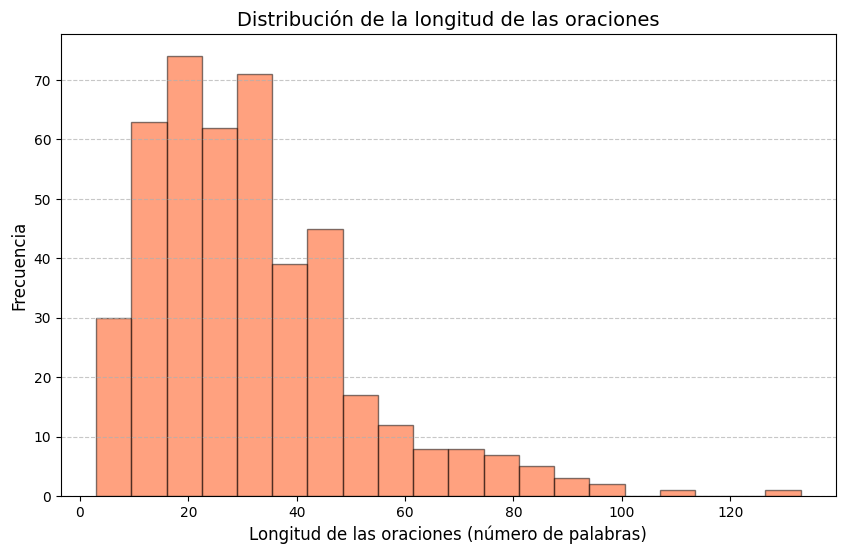

In [143]:
# Longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

# Distribución de oraciones
plt.figure(figsize=(10, 6))
plt.hist(length_sentences, bins=20, color='orangered', edgecolor='black', alpha = 0.5)
plt.title("Distribución de la longitud de las oraciones", fontsize=14)
plt.xlabel("Longitud de las oraciones (número de palabras)", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

En el gráfico se puede observar que:

- La mayoría de las oraciones tienen una longitud entre 0 y 50 palabras, con un pico entre 10 y 30 palabras.
- Hay pocas oraciones extremadamente largas (por encima de 100 palabras).
- La distribución es asimétrica hacia la derecha, lo que sugiere que las oraciones suelen ser cortas.

In [144]:
#En este caso, para determinar el máximo tamaño de contexto, elegimos el percentil 90
max_context_size = int(np.percentile(length_sentences, 90)-1)
print(f'max_context_size: {max_context_size}')

max_context_size: 54


###  Tokenizar

In [145]:
# Se instancia el tokenizador
tok = Tokenizer()

tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números (input palabras -> output números)
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [146]:
tokenized_sentences[0]

[709, 710, 5, 184, 1, 2, 88]

In [147]:
segmented_sentences[0]

['sun', 'tzu', 'el', 'arte', 'de', 'la', 'guerra']

En la variable `tokenized_sentences` tenemos los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de perplejidad.

In [148]:
def pad_and_concat(tokenized_sentences, max_context_size):
    """
    Apply padding to sentences so that all have the same length and concatenate them into a single tensor.
    """
    padded_sentences = []
    for sent in tokenized_sentences:
        subseq = [sent[:i+2] for i in range(len(sent)-1)]
        padded_sentences.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))
    return np.concatenate(padded_sentences, axis=0)

In [149]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

In [150]:
train_sequences = pad_and_concat(tokenized_sentences_train, max_context_size)
val_sequences = pad_and_concat(tokenized_sentences_val, max_context_size)
print(f"Dimensiones train_sequences: {train_sequences.shape}")
print(f"Dimensiones val_sequences shape: {val_sequences.shape}")

Dimensiones train_sequences: (11039, 55)
Dimensiones val_sequences shape: (2578, 55)


In [ ]:
# Definimos los conjuntos de entrenamiento / validación
X_train = train_sequences[:,:-1]
X_val = val_sequences[:,:-1]
y_train = train_sequences[:,-1]
y_val = val_sequences[:,-1]

Vamos a splitear las oraciones que tienen tamaño mayor al contexto máximo, para generarnos más secuencias de entrenamiento.

In [152]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [153]:
len(tok_sent)

1109

Ahora aumentamos los datos aprovechando que de una secuencia grande se pueden generar varias más pequeñas:


In [ ]:
tok_sent_augm = []

for sent in tok_sent:

  # Generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # Paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [ ]:
# Concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [156]:
train_seqs.shape

(50842, 55)

In [158]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

2821

In [ ]:
# Vemos índices para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'de': 1, 'la': 2, 'que': 3, 'y': 4, 'el': 5, 'los': 6, 'en': 7, 'a': 8, 'no': 9, 'se': 10, 'es': 11, 'las': 12, 'un': 13, 'si': 14, 'para': 15, 'cuando': 16, 'una': 17, 'por': 18, 'lo': 19, 'del': 20, 'enemigo': 21, 'sus': 22, 'terreno': 23, 'son': 24, 'con': 25, 'al': 26, 'su': 27, 'como': 28, 'tropas': 29, 'soldados': 30, 'tus': 31, 'ser': 32, 'puede': 33, 'ejército': 34, 'están': 35, 'victoria': 36, 'sin': 37, 'así': 38, 'tu': 39, 'esto': 40, 'está': 41, 'fuerza': 42, 'batalla': 43, 'pero': 44, 'adversarios': 45, 'manera': 46, 'puedes': 47, 'o': 48, 'más': 49, 'te': 50, 'ni': 51, 'general': 52, 'pueden': 53, 'sobre': 54, 'hacer': 55, 'fuerzas': 56, 'significa': 57, 'militares': 58, 'pues': 59, 'enemigos': 60, 'tanto': 61, 'lugar': 62, 'adversario': 63, 'sólo': 64, 'atacar': 65, 'ti': 66, 'todo': 67, 'debe': 68, 'entre': 69, 'militar': 70, 'territorio': 71, 'ellos': 72, 'tienen': 73, 'le': 74, 'sea': 75, 'espías': 76, 'planes': 77, 'tiene': 78, 'antes': 79, 'generales': 80, 'ataque'

In [160]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'el': 215, 'de': 282, 'la': 230, 'sun': 2, 'guerra': 17, 'tzu': 2, 'arte': 9, '1': 1, 'capítulo': 13, 'sobre': 31, 'evaluación': 2, 'vital': 1, 'no': 163, 'supervivencia': 2, 'bien': 14, 'conservación': 1, 'ello': 6, 'y': 257, 'dominio': 2, 'vida': 5, 'imperio': 1, 'importancia': 1, 'ocurrir': 1, 'le': 18, 'respecta': 1, 'del': 80, 'querido': 1, 'nosotros': 1, 'que': 239, 'reflexionar': 1, 'hacia': 11, 'lo': 74, 'a': 191, 'seriamente': 1, 'dar': 3, 'entre': 18, 'culpable': 1, 'forzoso': 1, 'nos': 1, 'para': 110, 'muerte': 10, 'todo': 22, 'mas': 1, 'camino': 10, 'una': 100, 'dice': 13, 'o': 33, 'es': 155, 'manejarla': 1, 'concierne': 2, 'pérdida': 1, 'estado': 1, 'indiferencia': 1, 'debe': 19, 'prueba': 2, 'en': 202, 'condiciones': 6, 'estos': 9, 'terreno': 59, 'tercero': 1, 'determinar': 4, 'los': 205, 'resultado': 5, 'hacer': 26, 'rivales': 3, 'quinto': 1, 'bandos': 3, 'cuarto': 1, 'vistas': 1, 'valorarla': 1, 'primero': 16, 'mando': 15, 'comparaciones': 3,


### Arquitectura del modelo

In [ ]:
# MODELO FINAL

model = Sequential()

model.add(Embedding(input_dim=vocab_size+1, output_dim=200, input_shape=(None,)))
model.add(LSTM(75, return_sequences=True))  # Devuelve secuencias intermedias
model.add(Dropout(0.4))
model.add(LSTM(75, return_sequences=False))  # Solo la última salida
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(128, activation='tanh', kernel_regularizer=l2(1e-4)))

# Salida de tamaño del vocabulario
model.add(Dense(vocab_size+1, activation='softmax'))

loss = SparseCategoricalCrossentropy()
optimizer = RMSprop(learning_rate=1e-4)
model.compile(loss=loss, optimizer=optimizer)

# Early stopping and checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

model.summary()


c:\Users\Usuario\anaconda3\envs\test\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, None, 200)      │       564,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, None, 75)       │        82,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, None, 75)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 75)             │        45,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 75)             │           300 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2822)           │       364,038 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,066,566 (4.07 MB)

 Trainable params: 1,066,416 (4.07 MB)

 Non-trainable params: 150 (600.00 B)

### Entrenamiento del modelo

In [163]:
print(X_train.shape)  # Debería ser (num_samples, sequence_length)
print(y_train.shape)  # Debería ser (num_samples, sequence_length)

(11039, 54)
(11039,)


In [164]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
# history_ppl = [] FLAG BORRAR
hist = model.fit(X_train, y_train,
                 validation_data=(X_val, y_val),
                 epochs=50, 
                 callbacks=[early_stopping],
                 batch_size=64)

Epoch 1/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 7.9512 - val_loss: 7.9372
Epoch 2/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 7.9240 - val_loss: 7.9137
Epoch 3/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 7.8866 - val_loss: 7.8834
Epoch 4/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 7.8269 - val_loss: 7.8622
Epoch 5/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 7.7154 - val_loss: 7.7453
Epoch 6/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 7.5054 - val_loss: 7.3759
Epoch 7/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 7.2052 - val_loss: 7.1300
Epoch 8/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 6.9259 - val_loss: 6.8518
Epoch 9/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 6.7799 - val_loss: 6.7050
Epoch 10/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 6.6121 - val_loss: 6.4870
Epoch 11/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 6.3906 - val_loss: 6.3515
Epoch 12/50
173/173 ━━━━━━━━━━━━━━━━━━━━

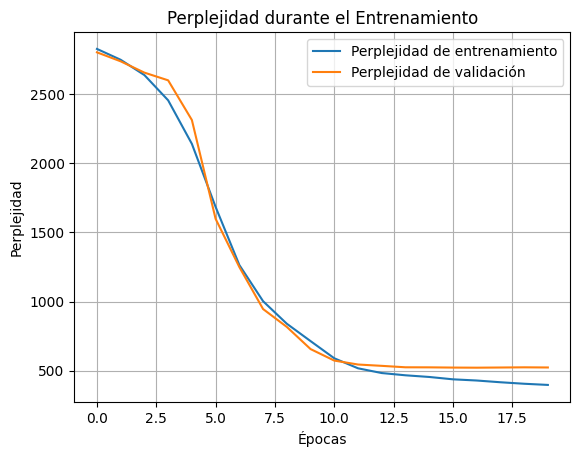

In [165]:
import matplotlib.pyplot as plt
import seaborn as sns

'''
# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()
'''


# Graficamos perplejidad:
# Calcula la perplejidad para entrenamiento y validación usando el historial de pérdidas
train_perplexities = np.exp(hist.history['loss'])
val_perplexities = np.exp(hist.history['val_loss'])

# Graficar la perplejidad
plt.plot(train_perplexities, label='Perplejidad de entrenamiento')
plt.plot(val_perplexities, label='Perplejidad de validación')
plt.xlabel("Épocas")
plt.ylabel("Perplejidad")
plt.legend()
plt.title("Perplejidad durante el Entrenamiento")
plt.grid()
plt.show()

Al graficar la perplejidad, se pueden observar varios puntos interesantes:
-   En las primeras 5 épocas, tanto la perplejidad del conjunto de entrenamiento como la de validación disminuyen rápidamente. Esto indica que el modelo está aprendiendo patrones significativos en los datos.
- Las curvas de entrenamiento y validación están muy cerca durante todo el entrenamiento, lo que indica que el modelo no está sobreajustando y generaliza bien a los datos de validación.
- Después de la época 10, la perplejidad se estabiliza para ambos conjuntos. Esto podría indicar que el modelo ha alcanzado un punto de saturación en términos de aprendizaje y que entrenar por más épocas no resultará en mejoras significativas (por eso también se aplica el early stopping).
- La diferencia entre las perplejidades de entrenamiento y validación es muy pequeña, lo que indica un buen equilibrio entre ajuste y generalización.

De acuerdo a todo lo anterior, se podría decir que el modelo está teniendo un buen desempeño.

### Generación de secuencias

In [ ]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words, temperature=0.8):
    output_text = seed_text
    for _ in range(n_words):
        # Codificar el texto
        encoded = tokenizer.texts_to_sequences([output_text])[0]
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

        # Predicción con temperatura ajustada
        probs = model.predict(encoded)[0]
        probs = np.exp(probs / temperature) / np.sum(np.exp(probs / temperature))  # Temperatura ajustada
        y_hat = np.random.choice(len(probs), p=probs)

        # Palabra correspondiente al índice predicho
        out_word = next((word for word, index in tokenizer.word_index.items() if index == y_hat), None)

        # Si no se encuentra la palabra, se detiene
        if not out_word:
            break

        # Restricción para evitar palabras repetidas consecutivamente
        # (para ajustar secuencia de mismas palabras x ej. "de de")
        if out_word in output_text.split()[-1:]:
            continue

        # Agregar la palabra al texto generado
        output_text += ' ' + out_word

    # Limpieza de repeticiones consecutivas
    output_text = ' '.join([word for i, word in enumerate(output_text.split()) if i == 0 or word != output_text.split()[i-1]])
    
    return output_text


In [ ]:
input_text='las armas son instrumentos de'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10, temperature=0.8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


'las armas son instrumentos de confidencial sin oportunidad ojos concordia daño acorralar planicie beben trata'

En este caso el modelo genera secuencias conservadoras, seleccionando palabras con mayor probabilidad en la distribución (si bien no tiene mayor sentido).

En el siguiente caso vamos a aumentar la temperatura, para ver el efecto que tiene sobre la generación de secuencias.

In [424]:
input_text='cuando un país se empobrece a causa de'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10, temperature=1.5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


'cuando un país se empobrece a causa de flanco nación obtener contradictorias estás especial empiezan insondable naturales nada'

En este caso, el modelo genera secuencias con mayor variabilidad. La probabilidad de seleccionar palabras menos probables aumenta, lo que introduce términos inusuales o incoherentes en el texto y por lo tanto el mismo tiene poca coherencia y parece más aleatorio.

Se evidencia que al aumentar la temperatura, el modelo da prioridad a explorar posibilidades más diversas pero menos fiables.


###  Beam search y muestreo aleatorio

In [425]:
# Funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [ ]:
from scipy.special import softmax

# Función que selecciona candidatos para el beam search
def select_candidates(pred, num_beams, vocab_size, history_probs, history_tokens, temp, mode):
    # Colecta todas las probabilidades para la siguiente búsqueda
    pred_large = []

    for idx, pp in enumerate(pred):
        pred_large.extend(np.log(pp + 1E-10) + history_probs[idx])

    pred_large = np.array(pred_large)

    # Penalización para palabras repetidas
    for token_seq in history_tokens:
        for token in token_seq:
            pred_large[token] -= 0.1  

    # Criterio de selección
    if mode == 'det':
        idx_select = np.argsort(pred_large)[::-1][:num_beams]  # Beam search determinista
    elif mode == 'sto':
        idx_select = np.random.choice(
            np.arange(pred_large.shape[0]),
            num_beams,
            p=softmax(pred_large / temp)
        )  # Beam search con muestreo aleatorio
    else:
        raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

    # Traducir a índices de token en el vocabulario
    new_history_tokens = np.concatenate(
        (np.array(history_tokens)[idx_select // vocab_size], np.array([idx_select % vocab_size]).T),
        axis=1
    )

    # Devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
    return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [ ]:
# Predicción con beam search.

salidas = beam_search(model,num_beams=10,
                      num_words=4,
                      input="una vez comenzada la batalla",
                      temp=0.5,
                      mode='sto')

In [ ]:
# Vemos las salidas

for i in range(0,len(salidas)):

        print(decode(salidas[i]))

['una vez comenzada la batalla de de y terrenos']
['una vez comenzada la batalla de de y verdadera']
['una vez comenzada la batalla de de el la']
['una vez comenzada la batalla de las el espuma']
['una vez comenzada la batalla y de de y']
['una vez comenzada la batalla y de de ocupar']
['una vez comenzada la batalla de de y victoria']
['una vez comenzada la batalla de de y persistencia']
['una vez comenzada la batalla de y un destaca']
['una vez comenzada la batalla de y la cuando']


Muchas salidas contienen términos repetitivos como "de de" o "de y", lo que podría indicar que el modelo tiene dificultades para evitar redundancias, incluso con penalización

Cuando se baja la temperatura, el modelo favorece palabras de mayor probabilidad, lo que resulta en menos diversidad (aunque las secuencias generadas tienen pequeñas variaciones, las opciones tienden a ser similares) y más coherencia semántica. Sin embargo, esta coherencia es limitada porque no logra generar texto completamente fluido y natural.

Ahora probamos aumentando la temperatura, y con una secuencia distinta.

In [471]:
salidas = beam_search(model,num_beams=10,
                      num_words=4,
                      input="cuando se agotan los recursos",
                      temp=3,
                      mode='sto')

In [472]:
# veamos las salidas

for i in range(0,len(salidas)):

        print(decode(salidas[i]))

['cuando se agotan los recursos falsa hacían suficientes contradictorias']
['cuando se agotan los recursos cuarta a ajustar retrocede']
['cuando se agotan los recursos cuarta a ajustar antiguo']
['cuando se agotan los recursos mismo así metódico punto']
['cuando se agotan los recursos mismo así metódico aprovecharte']
['cuando se agotan los recursos cuarta a faltas rodéalo']
['cuando se agotan los recursos mismo así metódico cuando']
['cuando se agotan los recursos mismo así metódico voluntad']
['cuando se agotan los recursos cuarta a ajustar fuegos']
['cuando se agotan los recursos cuarta a faltas accidentado']


En este caso, las salidas son más variadas en comparación con el ejemplo anterior, lo que refleja el impacto de una temperatura alta. Al explorar palabras de menor probabilidad, muchas secuencias carecen de sentido o parecen aleatorias. 